In [31]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [3]:
# read the data set
df=pd.read_csv('./data/gemstone.csv')
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [4]:
# Drop the id column due to irrelevance to the modeling task 
df=df.drop(columns='id', axis=1)

In [5]:
#this is how our data set looks like after dropping id column
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [6]:
#assign X(independent) and y(dependent)
X=df.drop(columns='price',axis=1)
y=df[['price']]

In [7]:
#let's see what we got in X
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77


In [8]:
#let's see what we got in y
y.head()

,price
0,13619
1,13387
2,2772
3,666
4,14453


In [9]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

print(categorical_cols,'|',numerical_cols)

Index(['cut', 'color', 'clarity'], dtype='object') | Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')


In [10]:
# Define the custom ranking for each ordinal/categorical variable
cut_categories = list(df.cut.value_counts().keys())
color_categories = list(df.color.value_counts().keys())
clarity_categories = list(df.clarity.value_counts().keys())
print(cut_categories)
print(color_categories)
print(clarity_categories)

['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
['G', 'E', 'F', 'H', 'D', 'I', 'J']
['SI1', 'VS2', 'VS1', 'SI2', 'VVS2', 'VVS1', 'IF', 'I1']


In [11]:
#create pipelines

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

In [12]:
#creating column transformer 
column_trans = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [13]:
#spliting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
#transform the test data and fit_transform the train data
X_train = pd.DataFrame(column_trans.fit_transform(X_train),columns=column_trans.get_feature_names_out())
X_test = pd.DataFrame(column_trans.transform(X_test),columns=column_trans.get_feature_names_out())

In [15]:
column_trans.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [16]:
X_train.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,0.132842,-0.668271,-1.088261
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,0.132842,-0.098646,-0.479273
2,1.529711,0.350728,-1.160823,1.426308,1.394848,1.441611,-0.872563,1.610227,-0.479273
3,1.896523,0.073206,0.923751,1.741402,1.711965,1.702290,0.132842,1.610227,0.738704
4,0.450852,1.738340,1.444895,0.562052,0.525040,0.703019,2.143651,0.470978,-0.479273


In [17]:
X_test.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.628006,0.258221,-0.118536,-0.599293,-0.580341,-0.571414,-0.872563,1.040602,-1.088261
1,2.608569,-2.146973,-0.118536,2.128516,2.201232,1.962969,1.138246,-1.237895,0.738704
2,-1.124281,-1.221899,0.923751,-1.373523,-1.413907,-1.469310,0.132842,-0.668271,1.956680
3,-1.016395,-0.574346,0.923751,-1.157458,-1.160213,-1.194148,0.132842,1.610227,1.956680
4,0.860819,0.628251,-0.639679,0.949167,0.987125,1.007145,-0.872563,0.470978,-1.088261


In [18]:
#Create an Evaluate Function to use after trainig

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1170.2031
- Mean Absolute Error: 728.6199
- R2 Score: 0.9160
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1162.2813
- Mean Absolute Error: 727.5198
- R2 Score: 0.9164


Lasso
Model performance for Training set
- Root Mean Squared Error: 1170.2623
- Mean Absolute Error: 729.5838
- R2 Score: 0.9160
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1162.4351
- Mean Absolute Error: 728.5276
- R2 Score: 0.9164


Ridge
Model performance for Training set
- Root Mean Squared Error: 1170.2032
- Mean Absolute Error: 728.6345
- R2 Score: 0.9160
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1162.2882
- Mean Absolute Error: 727.5340
- R2 Score: 0.9164


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 575.9905
- Mean Absolute Error: 295.9576
- R2 Sco

In [20]:
#let's see the results
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.978975
6,XGBRegressor,0.978290
5,Random Forest Regressor,0.977053
3,K-Neighbors Regressor,0.968522
4,Decision Tree,0.956933
0,Linear Regression,0.916403
2,Ridge,0.916402
1,Lasso,0.916381
8,AdaBoost Regressor,0.900690


In [21]:
#Hyperparameter tuning

# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(X_train, y_train.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.03, 'iterations': 600, 'depth': 10}
0.979547585718484


In [23]:
#create a function to print the evaluated results

def print_evaluated_results(model,X_train,y_train,X_test,y_test):
    ytrain_pred = model.predict(X_train)
    ytest_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [24]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 549.0560
- Mean Absolute Error: 290.9242
- R2 Score: 0.9815
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 578.7750
- Mean Absolute Error: 297.4346
- R2 Score: 0.9793


In [26]:
# Tunning KNN

# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(X_train, y_train)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 7}
0.9685005106275872


In [27]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 605.0671
- Mean Absolute Error: 310.3456
- R2 Score: 0.9775
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 708.1077
- Mean Absolute Error: 360.9563
- R2 Score: 0.9690


In [28]:
# Tuning XGBoost

# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(X_train, y_train.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.4}
0.9784332017099159


In [29]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 535.9680
- Mean Absolute Error: 285.4358
- R2 Score: 0.9824
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 592.9308
- Mean Absolute Error: 302.4872
- R2 Score: 0.9782


In [32]:
# VotingRegressor - fits several base regressors, each on the whole dataset

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(X_train, y_train.values.flatten())

print_evaluated_results(er,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 530.0649
- Mean Absolute Error: 280.0010
- R2 Score: 0.9828
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 582.0296
- Mean Absolute Error: 296.9296
- R2 Score: 0.9790


Model improved with Ensemble technique !

cat_pipeline__clarity    25.470346
num_pipeline__carat      20.177092
num_pipeline__y          16.832191
cat_pipeline__color      14.193466
num_pipeline__z          11.554149
num_pipeline__x          10.837376
cat_pipeline__cut         0.475621
num_pipeline__table       0.253050
num_pipeline__depth       0.206708
dtype: float64




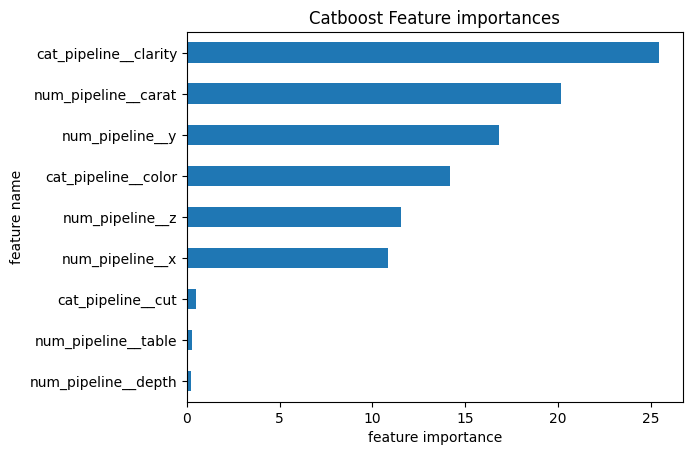

In [33]:
#List feature importance of the Catboost model

feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()